# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  The first three cells are for updating the packages in the online Udacity workspace. 

In [1]:
# for upgrading numpy to the latest version in the Udacity online workspace
!pip install --upgrade numpy

Requirement already up-to-date: numpy in /opt/conda/lib/python3.6/site-packages (1.17.2)


In [3]:
get_ipython().system('pip -q install ./python')

ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


In [2]:
!pip install prompt-toolkit==1.0.15

Import also the DDPPG agent.

In [4]:
from unityagents import UnityEnvironment
import numpy as np
import random
import time
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

Next, we will start the environment. Here we use the Udacity's online workspace for training. Hence we input the special Reacher environment available in the workspace. Note that it doesn't have visualisation of the trianing process.

In [5]:
# without visualisation in online Udacity workspace
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Alternatively, you can run the following cell in the local PC for visualising the game environment during training. You may have to change the path and filename as follows according to the OS you use.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

In [ ]:
# with visualisation
env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. DDPG in a glance

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

#### 3.1 Hyperparameter

The learning rate for both Actor and Critic is 1e-3 with soft update of target set to the same
1e-3. Gamma discount is 0.99 with weight decay set to 0. Replay Buffer has size of 1e6.
Batch size is 1024 with max time step of 1000 in each episode. A large Replay Buffer is
crucial in the success of the learning. Number of time steps plays an important role as the
agent needs to have enough time steps to have a good balance between exploitation and
exploration.

### 4. Training

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [8]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)

In [9]:
score_list = []

In [ ]:
def ddpg(n_episodes=2000, max_t=300, print_every=100, solve_score=30.0, learn_step=100, num_learn=10):
    avg_scores_deque = deque(maxlen=print_every)
    #score_list = []
    avg_score = 0.0
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        states = env_info.vector_observations                  # get the current state (for each agent)
        
        agent.reset()
        scores = np.zeros(num_agents)                         # initialize the score (for each agent)
        start_time = time.time()
        
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done) # send actions to the agent
            
            scores += rewards                        # update the score (for each agent)
            states = next_states
            
            if t%learn_step == 0 and t > learn_step:
                for _ in range(num_learn):
                    agent.start_learn()
                    
            if np.any(dones):
                duration = time.time() - start_time
                break 
                
        score_list.append(np.mean(scores))
        #scores.append(score)

        if i_episode % print_every == 0 and i_episode > print_every:
            avg_score = np.mean(score_list)
            print('\rEpisode {}\tAverage Score: {:.2f}\tDuration: {:.2f}'.format(i_episode, np.mean(score_list), duration))
        
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            
        if avg_score > solve_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, avg_score))
            break
    #return score_list

ddpg()

In [ ]:
scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
n_episodes=1000
max_t=300
print_every=10

scores_deque = deque(maxlen=print_every)
scores = []
for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
    state = env_info.vector_observations                  # get the current state (for each agent)

    #state = env.reset()
    agent.reset()
    score = 0
    for t in range(max_t):
        action = agent.act(state)
        env_info = env.step(action)[brain_name]           # send all actions to tne environment
        next_state = env_info.vector_observations         # get next state (for each agent)
        reward = env_info.rewards                         # get reward (for each agent)
        done = env_info.local_done                        # see if episode finished
        score += reward[0]                         # update the score (for each agent)
        state = next_state
        if done:
            break 
    scores_deque.append(score)
    scores.append(score)
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    if i_episode % print_every == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

In [10]:
def ddpg(n_episodes=2000, max_t=1000, print_every=10, learn_every=20, num_learn=10, goal_score=30):
    total_scores_deque = deque(maxlen=100)
    total_scores = []
    start_time = time.time()
    
    for i_episode in range(1, n_episodes+1):
        # Reset Env and Agent
        env_info = env.reset(train_mode=True)[brain_name]       # reset the environment    
        states = env_info.vector_observations                   # get the current state (for each agent)
        scores = np.zeros(num_agents)                            # initialize the score (for each agent)
        agent.reset()
        
        
        
        for t in range(max_t):
            actions = agent.act(states)
            
            env_info = env.step(actions)[brain_name]            # send all actions to the environment
            next_states = env_info.vector_observations          # get next state (for each agent)
            rewards = env_info.rewards                          # get reward (for each agent)
            
            dones = env_info.local_done                         # see if episode finished
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done) # send actions to the agent
            
            scores += env_info.rewards                           # update the score (for each agent)
            states = next_states                                # roll over states to next time step
            
            if t%learn_every == 0:
                #for _ in range(num_learn):
                agent.start_learn()
            
            if np.any(dones):                                   # exit loop if episode finished
                break
    
        mean_score = np.mean(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)
        total_scores_deque.append(mean_score)
        total_scores.append(mean_score)
        total_average_score = np.mean(total_scores_deque)
        duration = time.time() - start_time
        
        print('\rEpisode {}\tTotal Average Score: {:.2f}\tMean: {:.2f}\tMin: {:.2f}\tMax: {:.2f}\tDuration: {:.2f}'
              .format(i_episode, total_average_score, mean_score, min_score, max_score, duration))

        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tTotal Average Score: {:.2f}'.format(i_episode, total_average_score))  
            
        if total_average_score >= goal_score and i_episode >= 100:
            print('Problem Solved after {} epsisodes!! Total Average score: {:.2f}'.format(i_episode, total_average_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    
    return total_scores

scores = ddpg()

Episode 1	Total Average Score: 0.52	Mean: 0.52	Min: 0.52	Max: 0.52	Duration: 2.19


/home/workspace/ddpg_agent.py:105: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 2	Total Average Score: 0.62	Mean: 0.73	Min: 0.73	Max: 0.73	Duration: 12.80
Episode 3	Total Average Score: 0.42	Mean: 0.00	Min: 0.00	Max: 0.00	Duration: 23.60
Episode 4	Total Average Score: 0.35	Mean: 0.15	Min: 0.15	Max: 0.15	Duration: 34.51
Episode 5	Total Average Score: 0.38	Mean: 0.50	Min: 0.50	Max: 0.50	Duration: 45.39
Episode 6	Total Average Score: 0.49	Mean: 1.02	Min: 1.02	Max: 1.02	Duration: 56.39
Episode 7	Total Average Score: 0.47	Mean: 0.35	Min: 0.35	Max: 0.35	Duration: 67.35
Episode 8	Total Average Score: 0.52	Mean: 0.88	Min: 0.88	Max: 0.88	Duration: 78.31
Episode 9	Total Average Score: 0.62	Mean: 1.42	Min: 1.42	Max: 1.42	Duration: 89.31
Episode 10	Total Average Score: 0.72	Mean: 1.67	Min: 1.67	Max: 1.67	Duration: 100.23
Episode 10	Total Average Score: 0.72
Episode 11	Total Average Score: 0.80	Mean: 1.51	Min: 1.51	Max: 1.51	Duration: 111.23
Episode 12	Total Average Score: 0.81	Mean: 0.98	Min: 0.98	Max: 0.98	Duration: 122.22
Episode 13	Total Average Score: 0.87	Mean: 1

We can plot the graph of the change of scores over the episodes. We can conclude that, given the hyperparameters we have chosen for the agent, the learning of the agent starts slow at the initial 100 episodes. However, learning improves from episode 150 and onward. This could be due to the fact that the useful experiences accumulates in the training buffer, contributing to the faster, more effective learning in the middle of the episodes. 

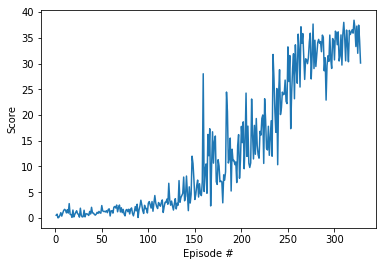

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

The weights of the actor and critic network are saved into two separate files for later use.

In [12]:
!ls

checkpoint_actor.pth	       Continuous_Control.ipynb  __pycache__
checkpoint_critic.pth	       ddpg_agent.py		 python
Continuous_Control-DDPG.ipynb  model.py			 unity-environment.log


When finished, you can close the environment.

In [ ]:
env.close()